# Fundamentals of Machine Learning (CSCI-UA.473)
## Lab 9: Clustering : K-means, Gaussian Mixtures, Density Based Clustering

In [1]:
# Import the necessary packages from sci-kit learn
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster import vq # Specifically uesful for K-means clustering
from sklearn import cluster  # Clustering algorithms such as K-means and agglomerative

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans 
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.manifold import MDS #Import the multidimensional scaling module
from scipy.spatial.distance import squareform #Import squareform, which creates a symmetric matrix from a vector
import time
import math
from sklearn import mixture
from scipy.stats import multivariate_normal as normal # Multivariate Gaussian distributions
from mpl_toolkits.axes_grid1 import ImageGrid
import time
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_blobs, fetch_openml, load_iris
import pandas as pd
import seaborn as sns
import torchvision
import torch
import torch.nn as nn
from sklearn_som.som import SOM
import scipy.cluster.hierarchy as sch

## K-means Clustering

We'll start by looking at the sci-kit learn implementation of K-means for a synthetic dataset that has distinct clusters.  The cell below generates a synthetic dataset with 4 well-separated clusters.

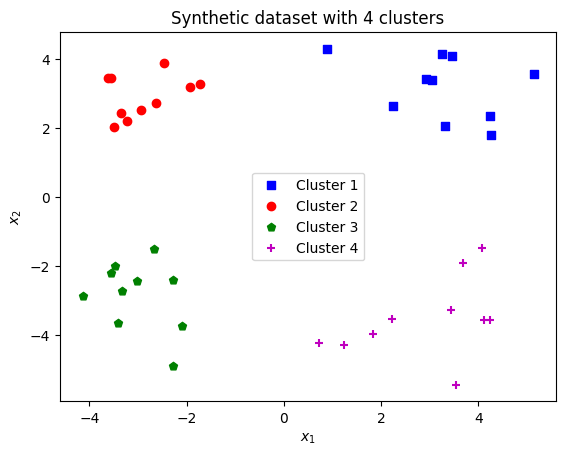

In [2]:
# Generate the synthetic dataset.
X1 = np.random.multivariate_normal(size = 10, mean = np.array([3, 3]), cov = np.identity(2))
X2 = np.random.multivariate_normal(size = 10, mean = np.array([-3, 3]), cov = np.identity(2))
X3 = np.random.multivariate_normal(size = 10, mean = np.array([-3, -3]), cov = np.identity(2))
X4 = np.random.multivariate_normal(size = 10, mean = np.array([3, -3]), cov = np.identity(2))

X = np.vstack([X1,X2,X3,X4])
plt.scatter(X1[:,0], X1[:,1], c = 'b', marker = 's', label = 'Cluster 1')
plt.scatter(X2[:,0], X2[:,1], c = 'r', marker = 'o', label = 'Cluster 2')
plt.scatter(X3[:,0], X3[:,1], c = 'g', marker = 'p', label = 'Cluster 3')
plt.scatter(X4[:,0], X4[:,1], c = 'm', marker = '+', label = 'Cluster 4')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Synthetic dataset with 4 clusters')
plt.legend()
plt.show()

## Distortion

A key quantity in helping determine a good number of clusters to use is the distortion
$$
J = \sum_{i=1}^N \|{\bf x}_i - \mu_{C(i)}\|^2
$$
where ${\bf x}_i$ are the data points, $C(i) \in \{1,\ldots,K\}$ is the cluster assignment for ${\bf x}_i$ and $\mu_j$ for $j=1,\ldots,K$ are the centers of the clusters.  Intuitively, the distortion captures the unexplained variation in the dataset after accounting for the clusters.  If $K = N$, then $\mu_{C(i)} = {\bf x}_i$ and the distortion will be 0.  In this case there is a cluster at every data point so intuitively there is no unexplained variation.  However, having a large number of clusters is often not very useful since we will likely be overfitting to noise in the data.  There will often be a certain point where the distortion starts to decrease more slowly.  This is called the "elbow method", which is what we plot below.

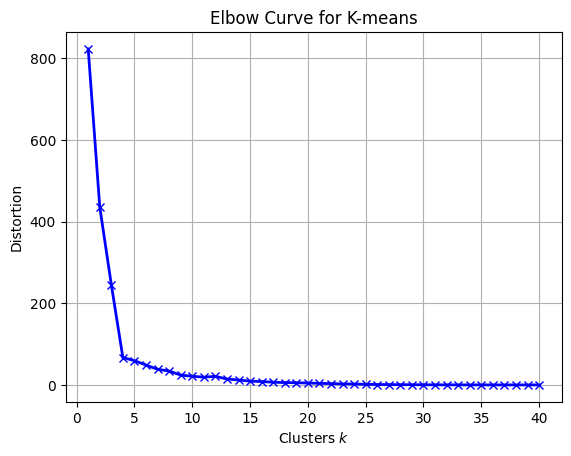

In [3]:
# Array to keep track of the distortions for K=1,...,N.
distortions = np.zeros(len(X))

for k in range(1, len(X) + 1):
    kmeans = cluster.KMeans(k, n_init="auto") # K-means object in sci-kit learn with k clusters.
    kmeans.fit(X)              # This is the line that actually runs the K-means algorithm.
    distortions[k-1] = kmeans.inertia_ # In sci-kit learn the distortion is called the inertia.

# Plot the results.
plt.plot(np.arange(1, len(X)+1, 1), distortions, 'b-x', lw = 2)
plt.xlabel(r'Clusters $k$')
plt.ylabel(r'Distortion')
plt.title(r'Elbow Curve for K-means')
plt.grid()
plt.show()

Indeed we see from the plot above that the distortion decreases rapidly up until $k=4$, which was the true number of clusters for our data.  After this point we begin overfitting to the noise and the distortion will not decrease as much.  A general heuristic is to choose $k$ where the kink, or elbow, in the curve occurs. 

This data was well-separated, however.  Let's see how the distortion behave whenever there is overlap between the clusters.  The cell below generates the new fake dataset with the clusters closer together.

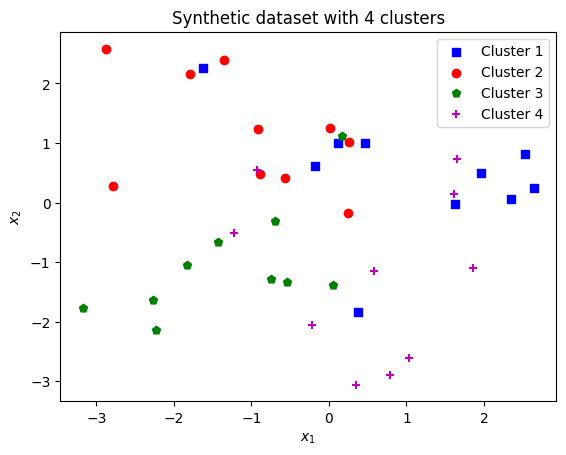

In [4]:
# Generate the new synthetic dataset.  The only difference from before is that the means are closer together now.
X1 = np.random.multivariate_normal(size = 10, mean = np.array([1, 1]), cov = np.identity(2))
X2 = np.random.multivariate_normal(size = 10, mean = np.array([-1, 1]), cov = np.identity(2))
X3 = np.random.multivariate_normal(size = 10, mean = np.array([-1, -1]), cov = np.identity(2))
X4 = np.random.multivariate_normal(size = 10, mean = np.array([1, -1]), cov = np.identity(2))

X = np.vstack([X1,X2,X3,X4])
plt.scatter(X1[:,0], X1[:,1], c = 'b', marker = 's', label = 'Cluster 1')
plt.scatter(X2[:,0], X2[:,1], c = 'r', marker = 'o', label = 'Cluster 2')
plt.scatter(X3[:,0], X3[:,1], c = 'g', marker = 'p', label = 'Cluster 3')
plt.scatter(X4[:,0], X4[:,1], c = 'm', marker = '+', label = 'Cluster 4')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Synthetic dataset with 4 clusters')
plt.legend()
plt.show()

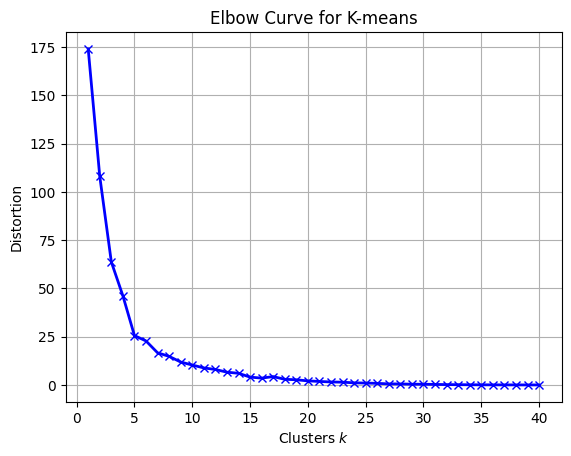

In [5]:
# Array of the distortions for k=1,...,N.
distortions = np.zeros(len(X))

# Same code as before.
for k in range(1, len(X) - 1):
    kmeans = cluster.KMeans(k, n_init='auto')
    kmeans.fit(X)
    distortions[k-1] = kmeans.inertia_

# Plot the results.
plt.plot(np.arange(1, len(X)+1, 1), distortions, 'b-x', lw = 2)
plt.xlabel(r'Clusters $k$')
plt.ylabel(r'Distortion')
plt.title(r'Elbow Curve for K-means')
plt.grid()
plt.show()

Now there is a more gradual decrease in the distortion and it is not as clear what choice of $k$ one should use.  

# Silhoutte Scores

![](Sscore.png)

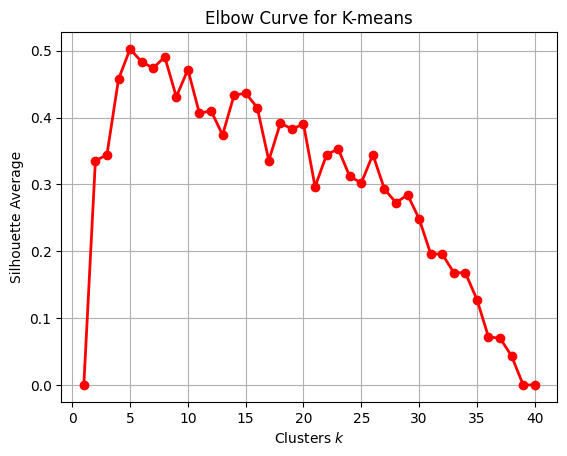

In [6]:
silhouettes = np.zeros(len(X))

# Same code as before.
for k in range(2, len(X) - 1):
    kmeans = cluster.KMeans(k, n_init='auto')
    labels = kmeans.fit_predict(X)
    silhouettes[k-1] = silhouette_score(X, labels)
    
plt.plot(np.arange(1, len(X)+1, 1), silhouettes, 'r-o', lw = 2)
plt.xlabel(r'Clusters $k$')
plt.ylabel(r'Silhouette Average')
plt.title(r'Elbow Curve for K-means')
plt.grid()
plt.show()

## Initializing the Cluster Centers 
One feature of K-means is that it is prone to becoming stuck in local minimum and is therefore sensitive to the initial cluster centers that are chosen.  The scipy implementation `kmeans2` allows for more flexibility in choosing the initial conditions so we also show it here as an alternative to sci-kit's implementation.  Now we see how the distortion changes after each iteration in K-means for different initializations.

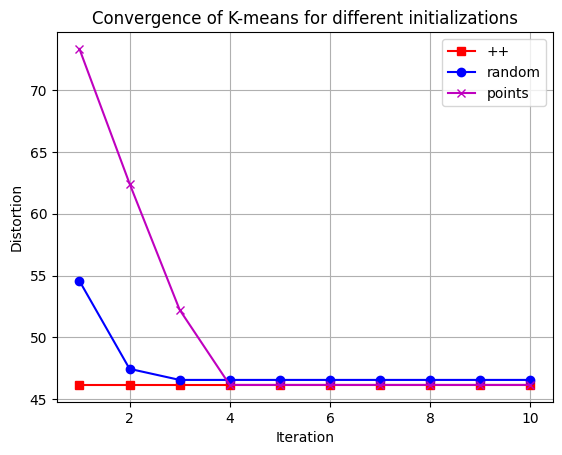

In [7]:
# Plot the distortion vs iteration for three different initial means.

# Helper function to compute the distortion using the data X and the computed cluster centers
# and labels for each point.
def distortion(X, centers, labels):
    N = X.shape[0]
    J = 0
    for i in range(N):
        J += np.linalg.norm(X[i] - centers[labels[i]])**2
    return J

# Only use 10 iterations of K-means.
max_iter = 10
distortions_1 = np.zeros(max_iter)
distortions_2 = np.zeros(max_iter)
distortions_3 = np.zeros(max_iter)

# 3 different initializations.
K = 4 # 4 clusters
np.random.seed(325) # Random seed is only chosen to emphasize difference between initializations.
                    # This line could be removed.
centers1, labels1 = vq.kmeans2(data = X, k = K, iter = 1, minit = '++')      # k-means++ initialization
centers2, labels2 = vq.kmeans2(data = X, k = K, iter = 1, minit = 'random')  # points sampled from a Gaussian
centers3, labels3 = vq.kmeans2(data = X, k = K, iter = 1, minit = 'points')  # points chosen from the dataset

distortions_1[0] = distortion(X, centers1, labels1)
distortions_2[0] = distortion(X, centers2, labels2)
distortions_3[0] = distortion(X, centers3, labels3)

for i in range(1, max_iter):
    # Do 1 iteration of K-means using the cluster centers from the last iteration.
    centers1, labels1 = vq.kmeans2(data = X, k = centers1, iter = 1, minit = 'matrix')
    centers2, labels2 = vq.kmeans2(data = X, k = centers2, iter = 1, minit = 'matrix')
    centers3, labels3 = vq.kmeans2(data = X, k = centers3, iter = 1, minit = 'matrix')
    
    distortions_1[i] = distortion(X, centers1, labels1)
    distortions_2[i] = distortion(X, centers2, labels2)
    distortions_3[i] = distortion(X, centers3, labels3)

# Plot the results
plt.plot(np.arange(1, max_iter + 1), distortions_1, 'r-s', label = '++')
plt.plot(np.arange(1, max_iter + 1), distortions_2, 'b-o', label = 'random')
plt.plot(np.arange(1, max_iter + 1), distortions_3, 'm-x', label = 'points')
plt.xlabel(r'Iteration')
plt.ylabel(r'Distortion')
plt.title(r'Convergence of K-means for different initializations')
plt.legend()
plt.grid()
plt.show()

The fact that all three curves have leveled-off indicates the K-means has converged.  However, the distortion is different meaning we have congevered to different local optima.

# K-Mediods Clustering <a class="anchor" id="second"></a>

The k-medoids algorithm is a clustering algorithm related to the k-means algorithm and the medoidshift algorithm. Both the k-means and k-medoids algorithms are partitional (breaking the dataset up into groups). K-means attempts to minimize the total squared error, while k-medoids minimizes the sum of dissimilarities between points labeled to be in a cluster and a point designated as the center of that cluster. In contrast to the k-means algorithm, k-medoids chooses datapoints as centers ( medoids or exemplars).

K-medoids is also a partitioning technique of clustering that clusters the data set of n objects into k clusters with k known a priori. A useful tool for determining k is the silhouette.

It could be more robust to noise and outliers as compared to k-means because it minimizes a sum of general pairwise dissimilarities instead of a sum of squared Euclidean distances. The possible choice of the dissimilarity function is very rich but in our applet we used the Euclidean distance.

A medoid of a finite dataset is a data point from this set, whose average dissimilarity to all the data points is minimal i.e. it is the most centrally located point in the set.

The most common realisation of k-medoid clustering is the Partitioning Around Medoids (PAM) algorithm and is as follows:

    * Initialize: randomly select k of the n data points as the medoids
    * Assignment step: Associate each data point to the closest medoid.
    * Update step: For each medoid m and each data point o associated to m swap m and o and compute the total cost of the configuration (that is, the average dissimilarity of o to all the data points associated to m). Select the mediod o with the lowest cost of the configuration.

Repeat alternating steps 2 and 3 until there is no change in the assignments. 

In [8]:
#define distance metric
euclidean = lambda x1,x2: np.sqrt(np.sum((x1-x2)**2,-1))
manhattan = lambda x1,x2: np.sum(np.abs(x1-x2), -1)
hamming = lambda x1,x2: np.sum((x1!=x2),-1)
dist_dict={"euclidean":euclidean, "manhattan":manhattan, "hamming":hamming}
class KMedoids:
    
    def __init__(self, K=5, max_iters=100, dist_fn=euclidean, repeats=10):
        self.K = K
        self.max_iters = max_iters                        #for computing each medoid
        self.dist_fn = dist_fn
        self.repeats = repeats                            #for several runs to compute medoids
    
    def fit(self, x):
        #note that medoids stores a list of K indices 
        n,d = x.shape
        distances = self.dist_fn(x[None,:,:], x[:,None,:])       #distance function for pairwise distance [n, n]
        best_cost = np.inf
        for r in range(self.repeats):
        #we repeat the process of finding medoids for self.repeats iterations
            medoids = np.random.choice(n, self.K, replace=False)      #randomly choose a list of k distinct indices from 0 to n-1
            for t in range(self.max_iters):
                membership = np.argmin(distances[medoids,:], axis=0)       #assign membership based on distance from the medoids
                new_medoids = medoids.copy()
                cost = 0
                for i in range(self.K):
                    cluster_inds = np.nonzero(membership == i)[0]                                    #returns the indices of points with membership i
                    cluster_dist = np.sum(distances[np.ix_(cluster_inds, cluster_inds)], axis=1)     #pairwise distance between points with membership i and summed over axis 1  
                    cost += np.min(cluster_dist)                                                     #compute the cost  for the 
                    new_medoids[i] = cluster_inds[np.argmin(cluster_dist)]                           #find the index of i-th medoids
                if np.allclose(new_medoids, medoids):
                    #print(f'converged after {t} iterations with the cost {cost}')
                    break
                medoids = new_medoids
            if cost < best_cost:
                best_medoids = medoids
                best_membership = membership
        return best_medoids, best_membership

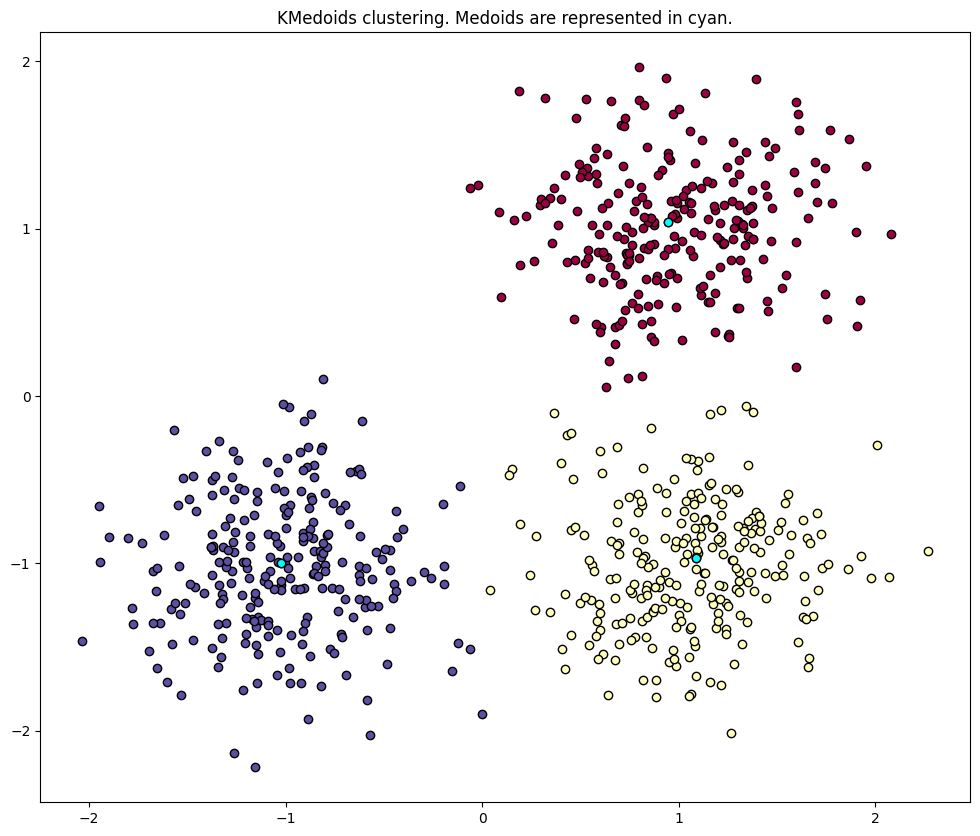

In [9]:
## K-Mediods Visualization
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = datasets.make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)
kmediods = KMedoids(K=3)
mediods, labels = kmediods.fit(X)
unique_labels = set(labels)
fig = plt.figure(figsize =(12, 10))
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = X[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )
plt.plot(
    X[mediods][:, 0],
    X[mediods][:, 1],
    "o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    markersize=6,
)

plt.title("KMedoids clustering. Medoids are represented in cyan.")
plt.show()

In [10]:
## Checking the representative digits that we get based on the dissimilarity measure used.
x_org, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
def plot_digits(data):
    num_plots = data.shape[0]
    fig = plt.figure(figsize=(num_plots, 10.*num_plots))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, num_plots), axes_pad=0.1)
    for i in range(num_plots):
        grid[i].imshow(data[i].reshape((28,28)))
    plt.show()

Distance Function used:  euclidean


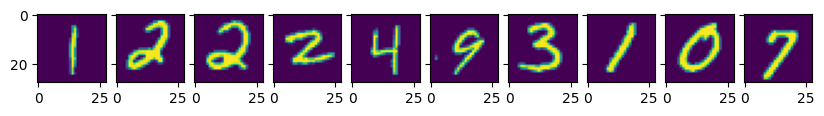

Distance Function used:  manhattan


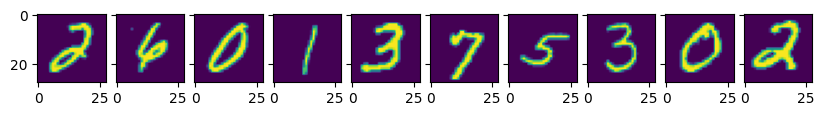

Distance Function used:  hamming


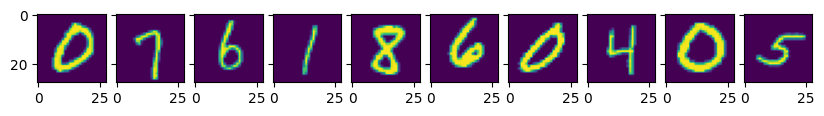

In [11]:
x = x_org.values[:1000]
for distance in dist_dict.keys():
    kmedoid = KMedoids(10, dist_fn=dist_dict[distance], repeats=1000)
    centers, _ = kmedoid.fit(x.reshape(-1, 784))
    print("Distance Function used: ", distance)
    plot_digits(x[centers])

## Why to use KMediods over KMeans

Pros:
1. _K-medoid is more flexible_: First of all, you can use k-medoids with any similarity measure. K-means however, may fail to converge - it really must only be used with distances that are consistent with the mean. So e.g. Absolute Pearson Correlation must not be used with k-means, but it works well with k-medoids.

2. _Robustness of medoid_: Secondly, the medoid as used by k-medoids is roughly comparable to the median (in fact, there also is k-medians, which is like K-means but for Manhattan distance). If you look up literature on the median, you will see plenty of explanations and examples why the median is more robust to outliers than the arithmetic mean. Essentially, these explanations and examples will also hold for the medoid. It is a more robust estimate of a representative point than the mean as used in k-means.

Cons:
1. _k-medoids is much more expensive_: That's the main drawback. Usually, PAM takes much longer to run than k-means. As it involves computing all pairwise distances, it is O(n^2*k*i); whereas k-means runs in O(n*k*i) where usually, k times the number of iterations is k*i << n.

## Gaussian mixture models and the EM algorithm

One disadvantage of K-means is that the clusters are restricted to be spherical and so it is heavily dependent on the scaling of the features.  A Gaussian Mixture Model (GMMs) has an extra covariance parameter which allows us to represent poorly-scaled (i.e. long ellipses) data. In addition, GMMs also allow for soft clustering where any point could be contributing to multiple clusters. 

Consider the following toy dataset generated from the Gaussian mixture model with parameters
$$
\phi = (0.5,\ 0.5),\quad \mu_0 = \begin{bmatrix}-3\\0\end{bmatrix},\quad \mu_1 = \begin{bmatrix}3\\0\end{bmatrix}
$$
and
$$
\Sigma_0 = \Sigma_1 = \begin{bmatrix}
1 & 0\\
0 & 100
\end{bmatrix}
$$
The dataset is plotted below.

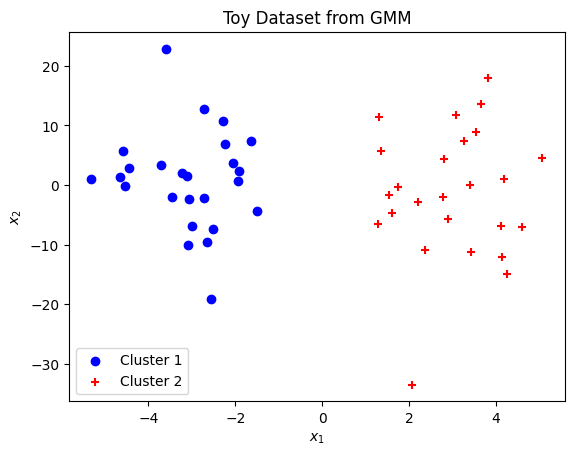

In [12]:
# Generate synthetic data
mu1 = np.array([-3, 0])
mu2 = np.array([3, 0])
Sigma = np.array([[1, 0], [0, 100]])
X1 = normal.rvs(mean = mu1, cov = Sigma, size = 25)
X2 = normal.rvs(mean = mu2, cov = Sigma, size = 25)

# Merge the data together.
X = np.vstack([X1, X2])

# Plot the data.
plt.scatter(X1[:,0], X1[:,1], c = 'b', marker = 'o', label = 'Cluster 1')
plt.scatter(X2[:,0], X2[:,1], c = 'r', marker = '+', label = 'Cluster 2')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Toy Dataset from GMM')
plt.legend()
plt.show()

Now we'll fit a Gaussian mixture model to this data and plot the contours for the covariance as well as the locations of the means.

3 iterations for EM to converge.


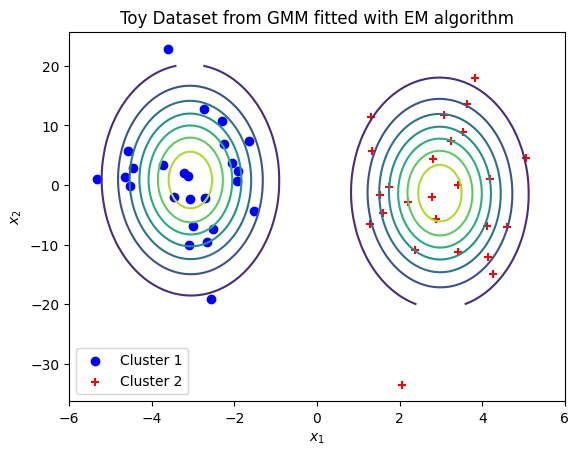

[-3  0] [3 0] [[-3.06124869  0.84774169]
 [ 2.97672295 -1.35474942]] [0.50003757 0.49996243]


In [13]:
# Create the Gaussian mixture model object with 2 components.  The 'tied' argument refers to the fact that we
# specify the covariances of both components to be the same.  This constrains the problem and reduces the 
# number of parameters we need to estimate.  We also provide the initial parameters which we happen to know already.
gmm = mixture.GaussianMixture(n_components = 2, covariance_type = 'tied', tol=1e-3, \
                              means_init = [mu1, mu2], precisions_init = np.linalg.inv(Sigma))

# The fit function uses the EM algorithm.
gmm.fit(X)

# Get the fitted means and covariances.
phi = gmm.weights_
mu = gmm.means_
cov = gmm.covariances_

# Can also get the number of iterations that was needed for convergence.
print("{:d} iterations for EM to converge.".format(gmm.n_iter_))

# Make a contour plot of the data.
xx = np.linspace(-6, 6, 100)
yy = np.linspace(-20, 20, 100)
XX, YY = np.meshgrid(xx, yy)
points = np.asarray([np.ravel(XX), np.ravel(YY)]).T
Z = phi[0]*normal.pdf(points, mean = mu[0], cov = cov) + phi[1]*normal.pdf(points, mean = mu[1], cov = cov)
ZZ = Z.reshape(XX.shape)

fig, ax = plt.subplots()
ax.contour(XX, YY, ZZ)
plt.scatter(X1[:,0], X1[:,1], c = 'b', marker = 'o', label = 'Cluster 1')
plt.scatter(X2[:,0], X2[:,1], c = 'r', marker = '+', label = 'Cluster 2')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Toy Dataset from GMM fitted with EM algorithm')
plt.legend()
plt.axis('tight')
plt.show()
print(mu1, mu2, mu, phi)

# Density-based spatial clustering of applications with noise (DBSCAN) <a class="anchor" id="third"></a>

DBSCAN requires two parameters: ε (eps) and the minimum number of points required to form a dense region (minPts). It starts with an arbitrary starting point that has not been visited. This point's ε-neighborhood is retrieved, and if it contains sufficiently many points, a cluster is started. Otherwise, the point is labeled as noise. Note that this point might later be found in a sufficiently sized ε-environment of a different point and hence be made part of a cluster.

If a point is found to be a dense part of a cluster, its ε-neighborhood is also part of that cluster. Hence, all points that are found within the ε-neighborhood are added, as is their own ε-neighborhood when they are also dense. This process continues until the density-connected cluster is completely found. Then, a new unvisited point is retrieved and processed, leading to the discovery of a future cluster or noise.

DBSCAN can be used with any distance function (as well as similarity functions or other predicates). The distance function (dist) can therefore be seen as an additional parameter.

The algorithm can be expressed in pseudocode as follows:

```
DBSCAN(DB, distFunc, eps, minPts) {
    C := 0                                                  /* Cluster counter */
    for each point P in database DB {
        if label(P) ≠ undefined then continue               /* Previously processed in inner loop */
        Neighbors N := RangeQuery(DB, distFunc, P, eps)     /* Find neighbors */
        if |N| < minPts then {                              /* Density check */
            label(P) := Noise                               /* Label as Noise */
            continue
        }
        C := C + 1                                          /* next cluster label */
        label(P) := C                                       /* Label initial point */
        SeedSet S := N \ {P}                                /* Neighbors to expand */
        for each point Q in S {                             /* Process every seed point Q */
            if label(Q) = Noise then label(Q) := C          /* Change Noise to border point */
            if label(Q) ≠ undefined then continue           /* Previously processed (e.g., border point) */
            label(Q) := C                                   /* Label neighbor */
            Neighbors N := RangeQuery(DB, distFunc, Q, eps) /* Find neighbors */
            if |N| ≥ minPts then {                          /* Density check (if Q is a core point) */
                S := S ∪ N                                  /* Add new neighbors to seed set */
            }
        }
    }
}
```

where RangeQuery is:

```
RangeQuery(DB, distFunc, Q, eps) {
    Neighbors N := empty list
    for each point P in database DB {                      /* Scan all points in the database */
        if distFunc(Q, P) ≤ eps then {                     /* Compute distance and check epsilon */
            N := N ∪ {P}                                   /* Add to result */
        }
    }
    return N
}

```

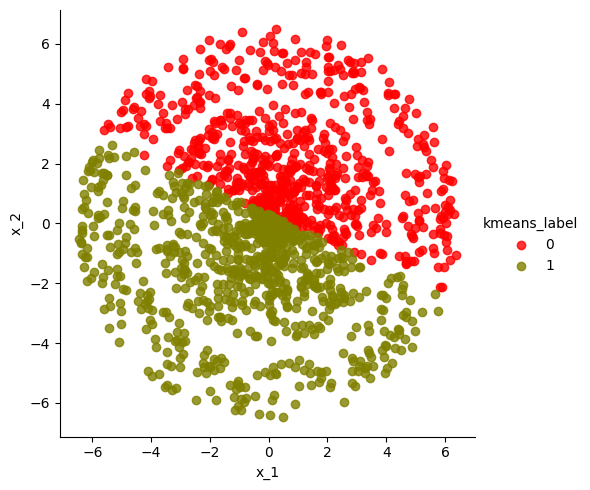

In [14]:
# Read the dataset
crater = pd.read_csv('crater.csv')
assert len (crater) == 1500
assert set (crater.columns) == set (['x_1', 'x_2', 'kmeans_label'])

with open ('crater_counts.txt', 'rt') as fp:
    true_counts = [int (c) for c in fp.read ().split (',')]
    assert sum (crater['kmeans_label'] == 0) == true_counts[0]
    assert sum (crater['kmeans_label'] == 1) == true_counts[1]

def make_scatter_plot (df, x="x_1", y="x_2", hue="label",
                       palette={0: "red", 1: "olive", 2: "blue", 3: "green"},
                       size=5,
                       centers=None):
    if (hue is not None) and (hue in df.columns):
        sns.lmplot (x=x, y=y, hue=hue, data=df, palette=palette,
                    fit_reg=False)
    else:
        sns.lmplot (x=x, y=y, data=df, fit_reg=False)

    if centers is not None:
        plt.scatter (centers[:,0], centers[:,1],
                     marker=u'*', s=500,
                     c=[palette[0]])

def make_scatter_plot2 (df, x="x_1", y="x_2", hue="label", size=5):
    if (hue is not None) and (hue in df.columns):
        sns.lmplot (x=x, y=y, hue=hue, data=df,
                    fit_reg=False)
    else:
        sns.lmplot (x=x, y=y, data=df, fit_reg=False)

make_scatter_plot (crater, hue='kmeans_label')

In [15]:
## DBSCAN Algorithm
def region_query (p, eps, X):
    # These lines check that the inputs `p` and `X` have
    # the right shape.
    _, dim = X.shape
    assert (p.shape == (dim,)) or (p.shape == (1, dim)) or (p.shape == (dim, 1))
    
    return np.linalg.norm (p - X, axis=1) <= eps

def index_set (y):
    """
    Given a boolean vector, this function returns
    the indices of all True elements.
    """
    assert len (y.shape) == 1

    return set (np.where (y)[0])

def find_neighbors (eps, X):
    m, d = X.shape
    neighbors = [] # Empty list to start
    for i in range (len (X)):
        n_i = index_set (region_query (X[i, :], eps, X))
        neighbors.append (n_i)
    assert len (neighbors) == m
    return neighbors

def find_core_points (s, neighbors):
    assert type (neighbors) is list
    assert all ([type (n) is set for n in neighbors])
    
    core_set = set ()
    for i, n_i in enumerate (neighbors):
        if len (n_i) >= s:
            core_set.add (i)
    return core_set

def expand_cluster (p, neighbors, core_set, visited, assignment):
    # Assume the caller performs Steps 1 and 2 of the procedure.
    # That means 'p' must be a core point that is part of a cluster.
    assert (p in core_set) and (p in visited) and (p in assignment)
    
    reachable = set (neighbors[p])  # Step 3
    while reachable:
        q = reachable.pop () # Step 4

        if q not in visited:
            visited.add (q) # Mark q as visited
            if q in core_set:
                reachable |= neighbors[q]
        if q not in assignment:
            assignment[q] = assignment[p]
        
    # This procedure does not return anything
    # except via updates to `visited` and
    # `assignment`.
    
def dbscan (eps, s, X):
    clusters = []
    point_to_cluster = {}
    
    neighbors = find_neighbors (eps, X)
    core_set = find_core_points (s, neighbors)
    
    assignment = {}
    next_cluster_id = 0

    visited = set ()
    for i in core_set: # for each core point i
        if i not in visited:
            visited.add (i) # Mark i as visited
            assignment[i] = next_cluster_id
            expand_cluster (i, neighbors, core_set,
                            visited, assignment)
            next_cluster_id += 1

    return assignment, core_set

Number of core points: 357
Number of clusters: 0
Number of unclassified points: 971


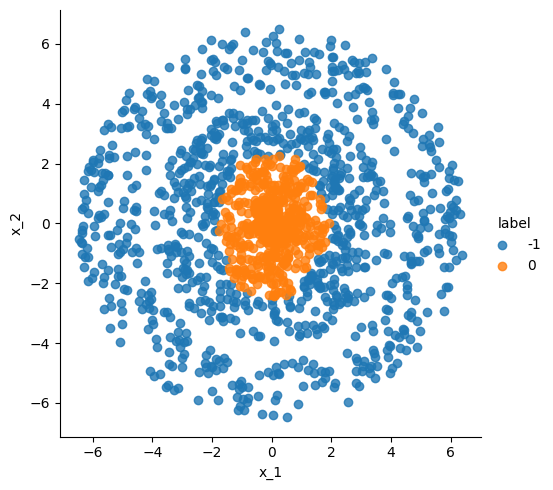

In [16]:
## Visualization
X = crater[['x_1', 'x_2']].values
assignment, core_set = dbscan (0.73, 50, X)

print ("Number of core points:", len (core_set))
print ("Number of clusters:", max (assignment.values ()))
print ("Number of unclassified points:", len (X) - len (assignment))

def plot_labels (df, labels):
    df_labeled = df.copy ()
    df_labeled['label'] = labels
    make_scatter_plot2 (df_labeled)

labels = [-1] * len (X)
for i, c in assignment.items ():
    labels[i] = c
plot_labels (crater, labels)


# Hierarchical Clustering <a class="anchor" id="fifth"></a>

Hierarchical clustering involves creating clusters that have a predetermined ordering from top to bottom. For example, all files and folders on the hard disk are organized in a hierarchy. There are two types of hierarchical clustering, Divisive and Agglomerative.

**Divisive method**

In this method we assign all of the observations to a single cluster and then partition the cluster to two least similar clusters. Finally, we proceed recursively on each cluster until there is one cluster for each observation.

**Agglomerative method**
		
In this method we assign each observation to its own cluster. Then, compute the similarity (e.g., distance) between each of the clusters and join the two most similar clusters. Finally, repeat steps 2 and 3 until there is only a single cluster left.

## Linkage or distance matrix

Before any clustering is performed, it is required to determine the proximity matrix containing the distance between each point using a distance function. Then, the matrix is updated to display the distance between each cluster. The following three methods differ in how the distance between each cluster is measured.

**Single Linkage** 		
In single linkage hierarchical clustering, the distance between two clusters is defined as the shortest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two closest points.
<img src=http://www.saedsayad.com/images/Clustering_single.png>

**Complete Linkage**		
In complete linkage hierarchical clustering, the distance between two clusters is defined as the longest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two furthest points.
<img src=http://www.saedsayad.com/images/Clustering_complete.png>

**Average Linkage**	
In average linkage hierarchical clustering, the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster. For example, the distance between clusters “r” and “s” to the left is equal to the average length each arrow between connecting the points of one cluster to the other.
<img src=http://www.saedsayad.com/images/Clustering_average.png>

## Dendograms

[Dendograms](https://en.wikipedia.org/wiki/Dendrogram) are tree diagrams frequently used to illustrate the arrangement of the clusters produced by hierarchical clustering. The clades are arranged according to how similar (or dissimilar) they are. Clades that are close to the same height are similar to each other; clades with different heights are dissimilar — the greater the difference in height, the more dissimilarity. 

In [17]:
df = pd.read_csv('./Mall_Customers.csv')
df.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [18]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


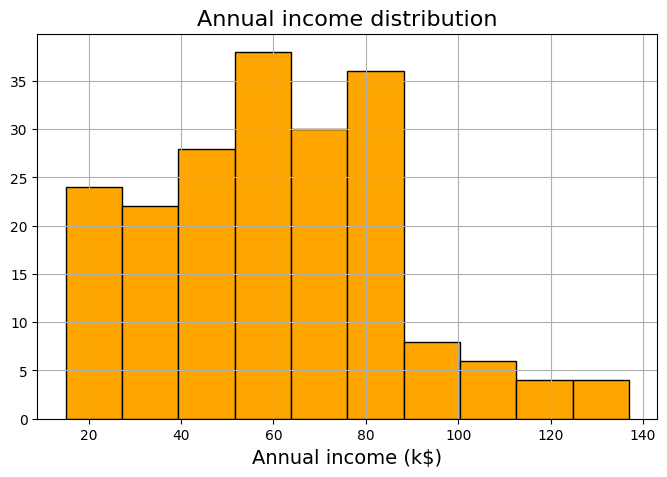

In [19]:
plt.figure(figsize=(8,5))
plt.title("Annual income distribution",fontsize=16)
plt.xlabel ("Annual income (k$)",fontsize=14)
plt.grid(True)
plt.hist(df['Annual Income (k$)'],color='orange',edgecolor='k')
plt.show()

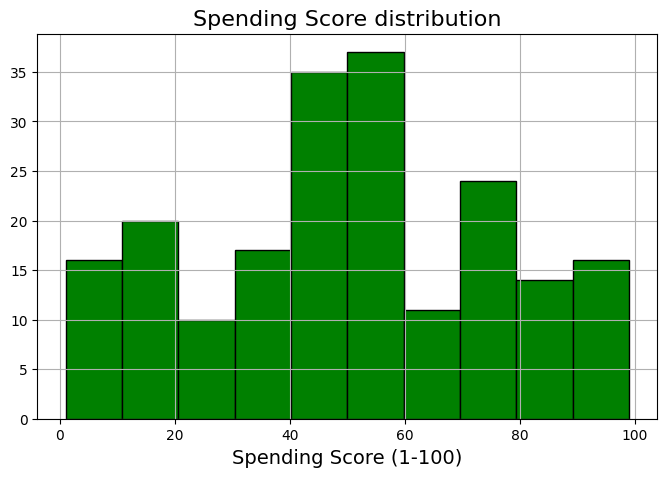

In [20]:
plt.figure(figsize=(8,5))
plt.title("Spending Score distribution",fontsize=16)
plt.xlabel ("Spending Score (1-100)",fontsize=14)
plt.grid(True)
plt.hist(df['Spending Score (1-100)'],color='green',edgecolor='k')
plt.show()

### So, is there a definitive correlation between annual income and spending score? - *Apparently not*

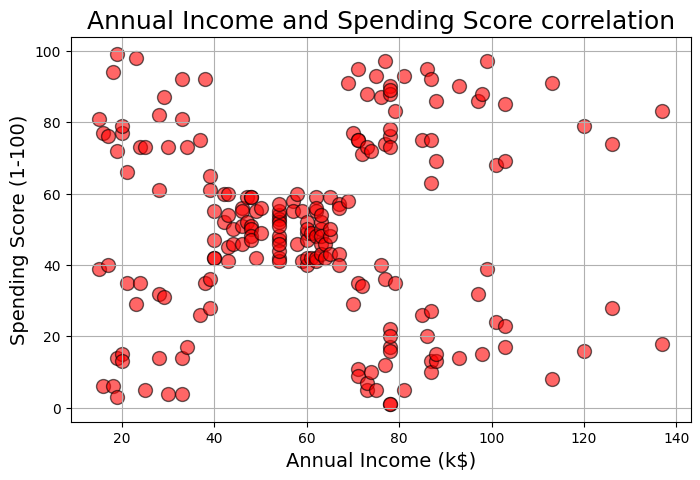

In [21]:
plt.figure(figsize=(8,5))
plt.title("Annual Income and Spending Score correlation",fontsize=18)
plt.xlabel ("Annual Income (k$)",fontsize=14)
plt.ylabel ("Spending Score (1-100)",fontsize=14)
plt.grid(True)
plt.scatter(df['Annual Income (k$)'],df['Spending Score (1-100)'],color='red',edgecolor='k',alpha=0.6, s=100)
plt.show()

### How about correlation between age and spending score? - *Apparently not*

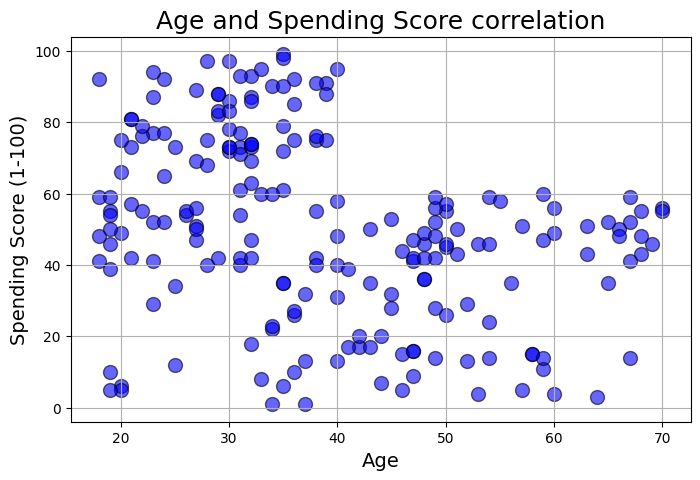

In [22]:
plt.figure(figsize=(8,5))
plt.title("Age and Spending Score correlation",fontsize=18)
plt.xlabel ("Age",fontsize=14)
plt.ylabel ("Spending Score (1-100)",fontsize=14)
plt.grid(True)
plt.scatter(df['Age'],df['Spending Score (1-100)'],color='blue',edgecolor='k',alpha=0.6, s=100)
plt.show()

## Strategy
** Therefore, we will explore cluserting the customers based on their annual income and spending score to see if there are distinguisbale clusters which the mall can target **

We could use k-means but we don't have any idea about the number of hidden clusters. We will see that hierarchial clustering with dendograms will give us a good insight on the optimal number of clusters.

## Dendograms

In [23]:
X = df.iloc[:,[3,4]].values

### _Ward_ distance matrix
We will use 'Ward' distance matrix for this dendogram.
$$d(u,v) = \sqrt{\frac{|v|+|s|}{T}d(v,s)^2+ \frac{|v|+|t|}{T}d(v,t)^2- \frac{|v|}{T}d(s,t)^2}$$

where **$u$** is the newly joined cluster consisting of clusters **$s$** and **$t$**, **$v$** is an unused cluster in the forest, **$T=|v|+|s|+|t|$**, and **$|*|$** is the cardinality of its argument. This is also known as the incremental algorithm.

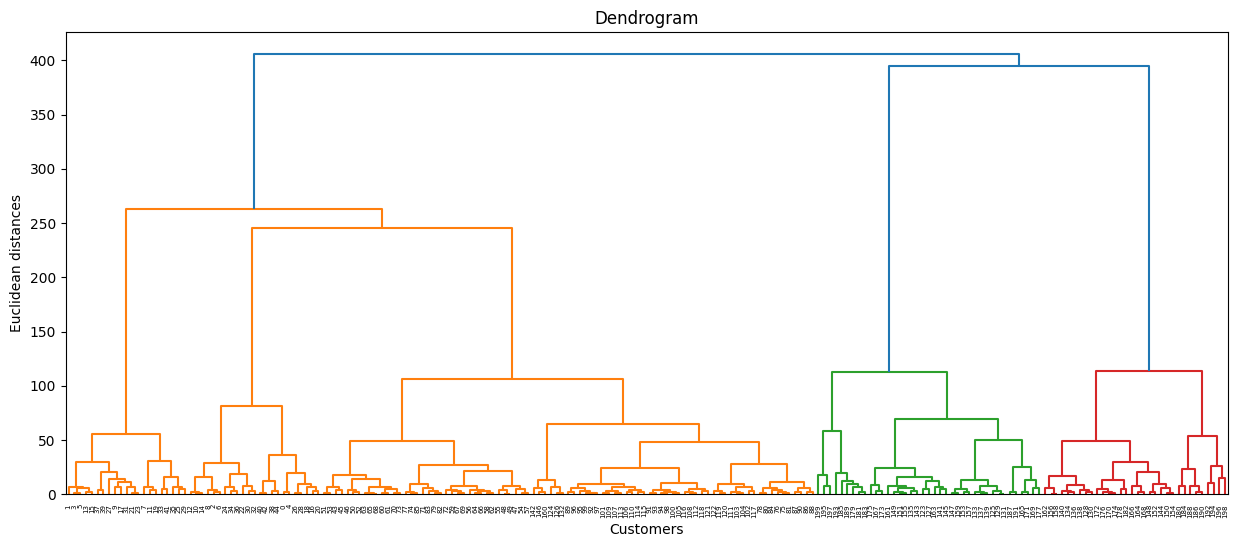

In [24]:
plt.figure(figsize=(15,6))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
#plt.grid(True)
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.show()

### Optimal number of clusters

Often, the optimal number of clusters can be found from a Dendogram is a simple manner.
* Look for the longest stretch of vertical line which is not crossed by any ***extended*** horizontal lines (here *extended* means horizontal lines i.e. the cluster dividers are extended infinitely to both directions).
* Now take any point on that stretch of line and draw an imaginary horizontal line.
* Count how many vertical lines this imaginary lines crossed.
* That is likely to be the optimal number of clusters.

**The idea is shown in the following figure. Here the optimal number of clusters could be 5.**

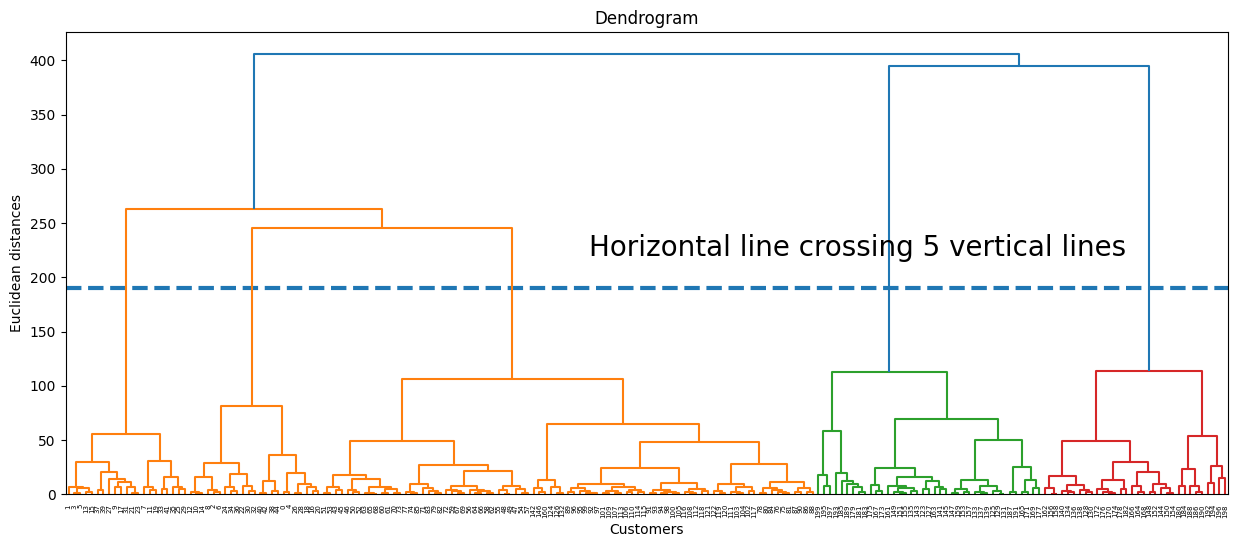

In [25]:
plt.figure(figsize=(15,6))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.hlines(y=190,xmin=0,xmax=2000,lw=3,linestyles='--')
plt.text(x=900,y=220,s='Horizontal line crossing 5 vertical lines',fontsize=20)
#plt.grid(True)
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.show()

In [26]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 5, metric = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X)

### Plot the clusters and label customer types
* _Careful_ - high income but low spenders
* _Standard_ - middle income and middle spenders
* **_Target group_ - middle-to-high income and high spenders (should be targeted by the mall)**
* _Careless_ - low income but high spenders (should be avoided because of possible credit risk)
* _Sensible_ - low income and low spenders

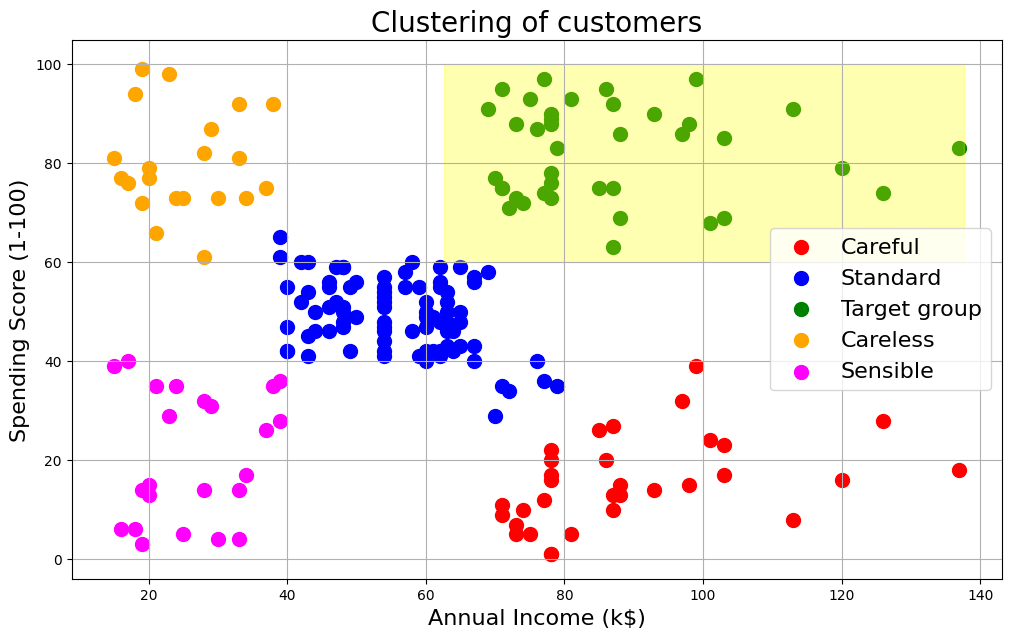

In [27]:
plt.figure(figsize=(12,7))
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 100, c = 'red', label = 'Careful')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 100, c = 'blue', label = 'Standard')
plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s = 100, c = 'green', label = 'Target group')
plt.scatter(X[y_hc == 3, 0], X[y_hc == 3, 1], s = 100, c = 'orange', label = 'Careless')
plt.scatter(X[y_hc == 4, 0], X[y_hc == 4, 1], s = 100, c = 'magenta', label = 'Sensible')
plt.title('Clustering of customers',fontsize=20)
plt.xlabel('Annual Income (k$)',fontsize=16)
plt.ylabel('Spending Score (1-100)',fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.axhspan(ymin=60,ymax=100,xmin=0.4,xmax=0.96,alpha=0.3,color='yellow')
plt.show()

## Verifying the optimal number of clusters by k-means algorithm

Given a set of observations $(x_1, x_2, …, x_n)$, where each observation is a d-dimensional real vector, [**k-means clustering**](https://en.wikipedia.org/wiki/K-means_clustering) aims to partition the *$n$* observations into *$k$* (≤ *$n$*) sets $S = {S_1, S_2, …, S_k}$ so as to minimize the within-cluster sum of squares (WCSS) (i.e. variance). Formally, the objective is to find:

$${\displaystyle {\underset {\mathbf {S} }{\operatorname {arg\,min} }}\sum _{i=1}^{k}\sum _{\mathbf {x} \in S_{i}}\left\|\mathbf {x} -{\boldsymbol {\mu }}_{i}\right\|^{2}={\underset {\mathbf {S} }{\operatorname {arg\,min} }}\sum _{i=1}^{k}|S_{i}|\operatorname {Var} S_{i}}$$

where $\mu_i$ is the mean of points in $S_i$

We run k-means++ model (k-means with carefully initialized centroids) iterating over number of clusters (1 to 15) and plot the ***within-cluster-sum-of-squares (WCSS) matric*** to determine the optimum number of cluster by elbow method

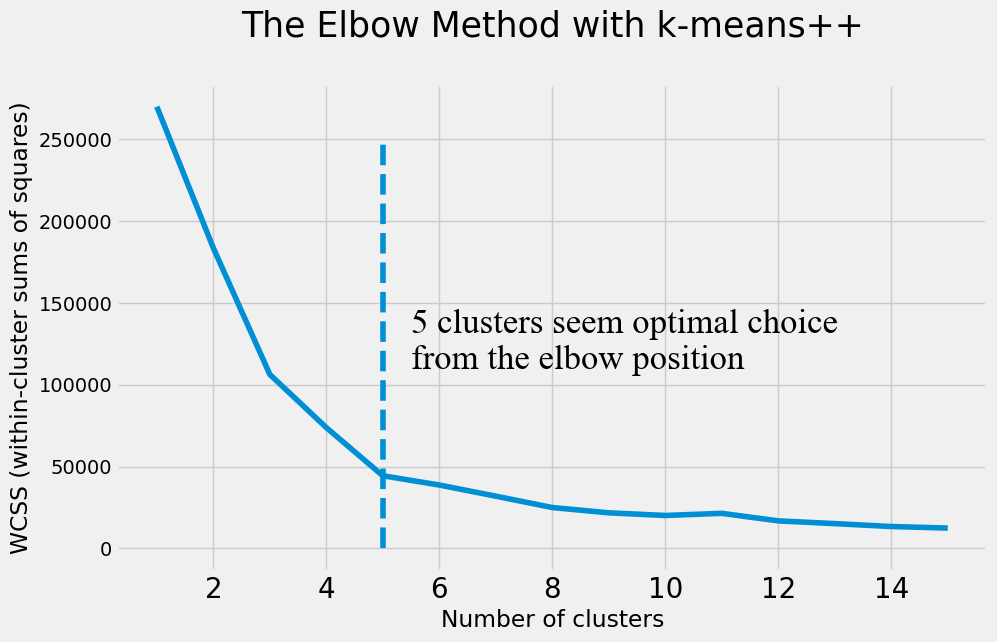

In [28]:
wcss = []
for i in range(1, 16):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

with plt.style.context(('fivethirtyeight')):
    plt.figure(figsize=(10,6))
    plt.plot(range(1, 16), wcss)
    plt.title('The Elbow Method with k-means++\n',fontsize=25)
    plt.xlabel('Number of clusters')
    plt.xticks(fontsize=20)
    plt.ylabel('WCSS (within-cluster sums of squares)')
    plt.vlines(x=5,ymin=0,ymax=250000,linestyles='--')
    plt.text(x=5.5,y=110000,s='5 clusters seem optimal choice \nfrom the elbow position',
             fontsize=25,fontdict={'family':'Times New Roman'})
    plt.show()